In [2]:
from typing import List, Set, Tuple
import os
import numpy as np

import cirq
import stim
import stimcirq

In [3]:
distances = [3, 5, 7]                       # Color code distance.
nsamples = 20                        # Number of samples/shots
depths = range(10, 600, 50)

noise_rate = 1e-3
noise = cirq.depolarize
simulator = stimcirq.StimSampler()

In [4]:
import dataclasses


@dataclasses.dataclass
class Tile:
    qubits: list
    color: str


def make_color_code_tiles(*, base_data_width):
    if not (base_data_width % 2 == 1 and base_data_width >= 3):
        raise ValueError(f"{base_data_width=} wasn't an odd number at least as large as 3.")
    w = base_data_width * 2 - 1

    def is_in_bounds(q: complex) -> bool:

        if q.imag < 0:

            return False
        if q.imag * 2 > q.real * 3:

            return False
        if q.imag * 2 > (w - q.real) * 3:

            return False
        return True


    tiles = []
    hexagon_offsets = [-1, +1j, +1j + 1, +2, -1j + 1, -1j]
    for x in range(1, w, 2):
        for y in range((x // 2) % 2, w, 2):
            q = x + 1j * y

            tile = Tile(
                color=['red', 'green', 'blue'][y % 3],

            
                qubits=[
                    q + d
                    for d in hexagon_offsets
                    if is_in_bounds(q + d)
                ],
            )

            if len(tile.qubits) in [4, 6]:
                tiles.append(tile)

    return tiles

def get_stabilizer_generators(distance: int):
    tiles = make_color_code_tiles(base_data_width=distance)
    all_qubits = {q for tile in tiles for q in tile.qubits}

    # Only difference here is with the chromobius notebook that we rever
    sorted_qubits = reversed(sorted(all_qubits, key=lambda q: (q.imag, q.real)))
    q2i = {q: i for i, q in enumerate(sorted_qubits)}

    sorted_tiles = []
    for tile in tiles:
        sorted_tiles.append([q2i[q] for q in tile.qubits])

    stabilizers_x = []
    stabilizers_z = []
    for tile in sorted_tiles:
        stab_x = ""
        stab_z = ""
        for i in range(int((3*distance**2+1)/4)):
            if i in tile:
                stab_x+="X"
                stab_z+="Z"
            else:
                stab_x+="I"
                stab_z+="I"
        stabilizers_x.append(stab_x)
        stabilizers_z.append(stab_z)

    return stabilizers_x + stabilizers_z

def stabilizers_to_encoder(stabilizers) -> stim.Circuit:
    
    tableau = stim.Tableau.from_stabilizers(
        stabilizers,
        allow_underconstrained=True,
    )
    # Note: Look at https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md
    # For the different method of encoding

    return tableau.to_circuit(method='graph_state')

In [5]:
def expectation(counts, logical0, logical1) -> Tuple[float, float]:
    # From YLF
    p0 = 0.0
    p1 = 0.0
    for state in logical0:
        if state in counts:
            p0 += counts[state]
    for state in logical1:
        if state in counts:
            p1 += counts[state]
    obs_value = (p0-p1)/(p0+p1) if p0+p1 > 0 else None
    prop_cw = (p0+p1) / sum(counts.values())
    return obs_value, prop_cw

In [6]:
def get_encoding(distance) -> Tuple[Set[int], Set[int], List[cirq.LineQubit], cirq.Circuit]:
    generator_strs = get_stabilizer_generators(distance)
    n = len(generator_strs[0])
    qreg = cirq.LineQubit.range(n)

    encoding_circuit = stimcirq.stim_circuit_to_cirq_circuit(stabilizers_to_encoder([stim.PauliString(s) for s in generator_strs]))

    if(os.path.exists(f"cw-d={distance}.txt")):
        logical0 = set()
        with open(f"cw-d={distance}.txt") as fp:
            for line in fp.readlines():
                logical0.add(int(line))

    else:
        encoding0 = encoding_circuit + [cirq.measure(qreg, key="m")]
        logical0 = set(simulator.run(encoding0, repetitions=100*2**(n//2)).histogram(key='m').keys())
        with open(f"cw-d={distance}.txt", "w") as fp:
            for cw in logical0:
                fp.write(f"{cw}\n")

    logical1 = set(int("".join(["0" if ch=="1" else "1" for ch in ["0"]*(n-len(bin(cw)[2:])) + list(bin(cw)[2:])]), 2) for cw in logical0)

    return logical0, logical1, qreg, encoding_circuit

# X experiment

## Unmitigated

In [8]:
unmit_evs = []
unmit_vars = []
for depth in depths:
    evs = []
    for _ in range(nsamples):
        c = cirq.Circuit([cirq.X.on(cirq.LineQubit(0))]*depth).with_noise(noise(noise_rate))
        c.append(cirq.H.on(cirq.LineQubit(0)))
        c.append(cirq.measure(cirq.LineQubit(0), key="m"))
        counts = simulator.run(c, repetitions=100_000).histogram(key="m")
        ev = (counts[0] - counts[1]) / 100_000
        evs.append(ev)
    ev_mean = np.mean(evs)
    ev_var = np.var(evs)
    print(ev_mean, ev_var)
    unmit_evs.append(ev_mean)
    unmit_vars.append(ev_var)

0.0007419999999999999 4.3332360000000004e-06
0.0003020000000000001 9.862476e-06
0.00026199999999999997 8.836836e-06
0.001294 6.888884e-06
-0.000721 1.0281859000000002e-05
0.0008909999999999998 2.423699e-06
0.000758 8.240315999999998e-06
0.00035899999999999994 3.965858999999999e-06
0.00101 8.09346e-06
0.0014780000000000004 8.971676e-06
0.001022 8.825596e-06
-0.00038199999999999996 8.234836e-06


## Mitigated

In [ ]:
all_mit_evs = []
all_mit_vars = []
for distance in distances:

    logical0, logical1, qreg, encoding_circuit = get_encoding(distance)
    n = len(qreg)

    print(f"{len(logical0)} code words for distance {distance}")

    mit_evs = []
    mit_vars = []

    for depth in depths:
        ev_sample = []
        for _ in range(nsamples):
            noisy_circuit = encoding_circuit.copy()
            for _ in range(depth):
                noisy_circuit.append(cirq.X.on_each(qreg))

            noisy_circuit.append(cirq.H.on_each(qreg))
            noisy_circuit = noisy_circuit.with_noise(noise(noise_rate))
            noisy_circuit.append(cirq.measure(qreg, key="m"))

            counts = simulator.run(noisy_circuit, repetitions=max(100*2**(n//2), 100_000)).histogram(key='m')
            ev, p = expectation(counts, logical0, logical1)
            ev_sample.append(ev)
        
        ev_mean = np.mean(ev_sample)
        ev_var = np.var(ev_sample)
        print(ev_mean, ev_var)
        mit_evs.append(ev_mean)
        mit_vars.append(ev_var)
    
    all_mit_evs.append(mit_evs)
    all_mit_vars.append(mit_vars)


8 code words for distance 3
1.3936634576015243e-05 1.0339820426405398e-05
0.000586346603140364 6.82709768907275e-06
-0.0013802129637862119 1.6128057009332597e-05
-0.0003386191570002925 2.1927144325163784e-05
-0.00115796117630983 2.2694301151736286e-05
0.00044813542286641723 1.1199678742842195e-05
3.6630799310408165e-05 2.1297239638104546e-05
-0.0018388500724044687 5.349989872942503e-05
-0.0010163758416931851 3.935908972058068e-05
0.0005853906718823324 7.346325582216256e-05
0.0012077866970354235 5.3812850613177475e-05
-0.0007353489270433456 7.465041250973066e-05
512 code words for distance 5
0.0020799541712691627 1.6021630923396265e-05
0.0016337831216262067 3.3547986164078684e-05
0.003449289230671465 8.812075503158636e-05
-0.000525558082920642 0.00010309522167422454
0.004717273120688139 0.00017074439297716425
0.0021326992513200174 0.00020020145018511862
0.001040464482236872 0.00032980176985999683
-0.0066970980771088665 0.0008173301388641346
-0.003104888419965611 0.0012277094019584503
0.

In [15]:
all_mit_vars = [
    [1.0339820426405398e-05, 6.82709768907275e-06, 1.6128057009332597e-05, 2.1927144325163784e-05, 2.2694301151736286e-05, 1.1199678742842195e-05, 2.1297239638104546e-05, 5.349989872942503e-05, 3.935908972058068e-05, 7.346325582216256e-05, 5.3812850613177475e-05, 7.465041250973066e-05],
    [1.6021630923396265e-05, 3.3547986164078684e-05, 8.812075503158636e-05, 0.00010309522167422454, 0.00017074439297716425, 0.00020020145018511862, 0.00032980176985999683, 0.0008173301388641346, 0.0012277094019584503, 0.0017733966911096925, 0.0014511353822084317, 0.0028114713237320814],
    [8.930847039318645e-07, 2.227294575415262e-06, 1.0758882126723371e-05, 1.4354062255442741e-05, 5.334519035041855e-05, 0.00012804776745363813, 0.0003561516121953692, 0.0013006425154044247, 0.002463813158124622, 0.003405235058914942, 0.002072419246520106, 0.002576179618411764]
]

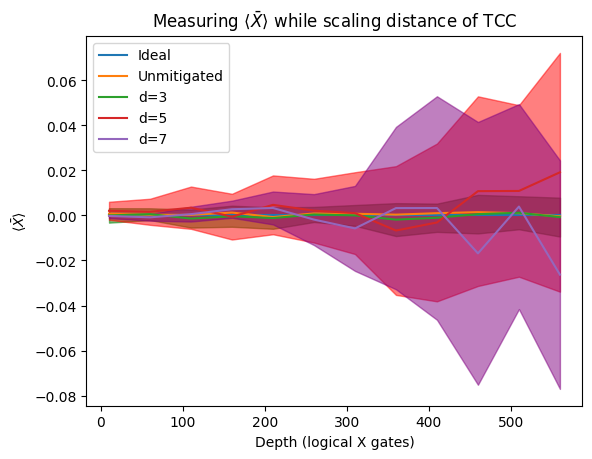

In [24]:
import matplotlib.pyplot as plt

plt.plot(depths, [0.0]*len(depths), label="Ideal")
plt.plot(depths, unmit_evs, label="Unmitigated")
plt.fill_between(
    depths,
    np.array(unmit_evs) - np.array(unmit_vars),
    np.array(unmit_evs) + np.array(unmit_vars),
    color="orange",
    alpha=0.5
)
colors = ["green", "red", "purple"]
for i, d in enumerate(distances):
    plt.plot(depths, all_mit_evs[i], label=f"d={d}")
    plt.fill_between(
        depths,
        np.array(all_mit_evs[i]) - np.sqrt(np.array(all_mit_vars[i])),
        np.array(all_mit_evs[i]) + np.sqrt(np.array(all_mit_vars[i])),
        color=colors[i],
        alpha=0.5
    )

plt.title("Measuring $\\langle \\bar{X}\\rangle$ while scaling distance of TCC")
plt.ylabel("$\\langle \\bar{X}\\rangle$")
plt.xlabel("Depth (logical X gates)")
plt.legend()

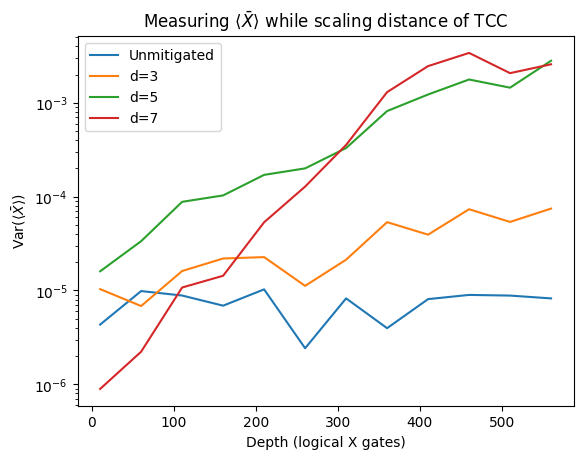

In [19]:
# plt.plot(depths, [0.0]*len(depths), label="Ideal")
plt.semilogy(depths, unmit_vars, label="Unmitigated")

for i, d in enumerate(distances):
    plt.semilogy(depths, all_mit_vars[i], label=f"d={d}")

plt.title("Measuring $\\langle \\bar{X}\\rangle$ while scaling distance of TCC")
plt.ylabel("Var$(\\langle \\bar{X}\\rangle)$")
plt.xlabel("Depth (logical X gates)")
plt.legend()

In [26]:
import csv
with open("mem-x-mean.csv", "w") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(depths)
    writer.writerows(all_mit_evs)

In [27]:
with open("mem-x-var.csv", "w") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(depths)
    writer.writerows(all_mit_vars)